In [4]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [5]:
# data_raw = pd.read_csv("../data/winequality-white.processed.csv")
# data_train, data_test = train_test_split(data_raw, test_size=0.2)

data_train = pd.read_csv("../data/winequality-white.processed.csv")
data_test = pd.read_csv("../data/winequality-white.randTest.csv")

x_train = data_train.iloc[:, 1 :-2].values
y_train = data_train[["label"]].values

x_test = data_test.iloc[:, 1 :-2].values
y_test = data_test[["label"]].values
baseline = data_test[["baseline"]].values

In [6]:
batch_size = 64

dataloader_train = DataLoader(TensorDataset(torch.tensor(x_train, requires_grad=True).float(), torch.tensor(y_train).float()),
                              shuffle=True, batch_size=batch_size)

dataloader_test = DataLoader(TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float(), torch.tensor(baseline).float()),
                              shuffle=True, batch_size=batch_size)

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [8]:
n_bins = 8

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.MLPs = nn.Sequential(
            nn.Linear(n_bins * n_bins + 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        logits = self.MLPs(x)
        return logits
    
model = NeuralNetwork().to(device=device)
print(model)

NeuralNetwork(
  (MLPs): Sequential(
    (0): Linear(in_features=68, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=1, bias=True)
  )
)


In [9]:
def compute_gradient(qx, qy, rx, ry, n_bins):
    grad = np.zeros((n_bins, n_bins))

    for i in range(qx):
        for j in range(qy):
            grad[i][j] = 1

    for i in range(qx):
        grad[i][qy] = ry 
    
    for j in range(qy):
        grad[qx][j] = rx 

    grad[qx][qy] = rx * ry
    
    grad = np.append(grad.reshape(-1), [0, 0, 0, 0])
    grad = grad.reshape(1, grad.size)
    return grad

In [10]:
def build_tensor_gradient(X, n_bins):
    grad = np.empty((0, n_bins * n_bins + 4))
    for i in range(X.shape[0]):
        qx = np.int64(X[i][-4])
        qy = np.int64(X[i][-3])
        rx = X[i][-2]
        ry = X[i][-1]
        grad = np.append(grad, compute_gradient(qx, qy, rx, ry, n_bins), axis=0)
    return torch.tensor(grad)

In [35]:
def train(dataloader, model, n_bins, alpha, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss_val = loss_fn(pred, y)

        grad_pred, = torch.autograd.grad(
            pred, X, grad_outputs=pred.data.new(pred.shape).fill_(1),
            create_graph=True
        )
        grad_pred = grad_pred.type(torch.float64)
        grad_real = build_tensor_gradient(X.cpu().detach(), n_bins)
        grad_real = grad_real.to(device)
        loss_grad = loss_fn(grad_pred, grad_real)

        loss = alpha * loss_val + (1 - alpha) * loss_grad
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [12]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y, b in dataloader:
            X, y, b = X.to(device), y.to(device), b.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    r2 = r2_score(pred.cpu(), y.cpu())
    b_r2 = r2_score(b.cpu(), y.cpu())
    print(f"Test Error: \n R2 Score: {r2:>8f}, Baseline R2 Score: {b_r2:>8f}, Avg loss: {test_loss:>8f} \n")

    return test_loss, r2, b_r2

In [13]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [36]:
epochs = 500

arr_loss = []
arr_r2 = []
arr_br2 = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader=dataloader_train, model=model, n_bins=n_bins, alpha=0.5, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, r2, b_r2 = test(dataloader=dataloader_test, model=model, loss_fn=loss_fn)
    arr_loss.append(test_loss)
    arr_r2.append(r2)
    arr_br2.append(b_r2)

print("Done!")

Epoch 1
-------------------------------
loss: 0.471247  [   64/66000]
loss: 0.351270  [ 6464/66000]
loss: 0.272190  [12864/66000]
loss: 0.303955  [19264/66000]
loss: 0.254320  [25664/66000]
loss: 0.258000  [32064/66000]
loss: 0.228370  [38464/66000]
loss: 0.193328  [44864/66000]
loss: 0.171029  [51264/66000]
loss: 0.193516  [57664/66000]
loss: 0.182500  [64064/66000]
Test Error: 
 R2 Score: -9.695568, Baseline R2 Score: 0.999811, Avg loss: 0.062592 

Epoch 2
-------------------------------
loss: 0.152500  [   64/66000]
loss: 0.201620  [ 6464/66000]
loss: 0.162957  [12864/66000]
loss: 0.146004  [19264/66000]
loss: 0.177486  [25664/66000]
loss: 0.160963  [32064/66000]
loss: 0.154746  [38464/66000]
loss: 0.173744  [44864/66000]
loss: 0.177390  [51264/66000]
loss: 0.162172  [57664/66000]
loss: 0.162515  [64064/66000]
Test Error: 
 R2 Score: -6.463784, Baseline R2 Score: 0.999558, Avg loss: 0.120117 

Epoch 3
-------------------------------
loss: 0.155740  [   64/66000]
loss: 0.156131  [ 64

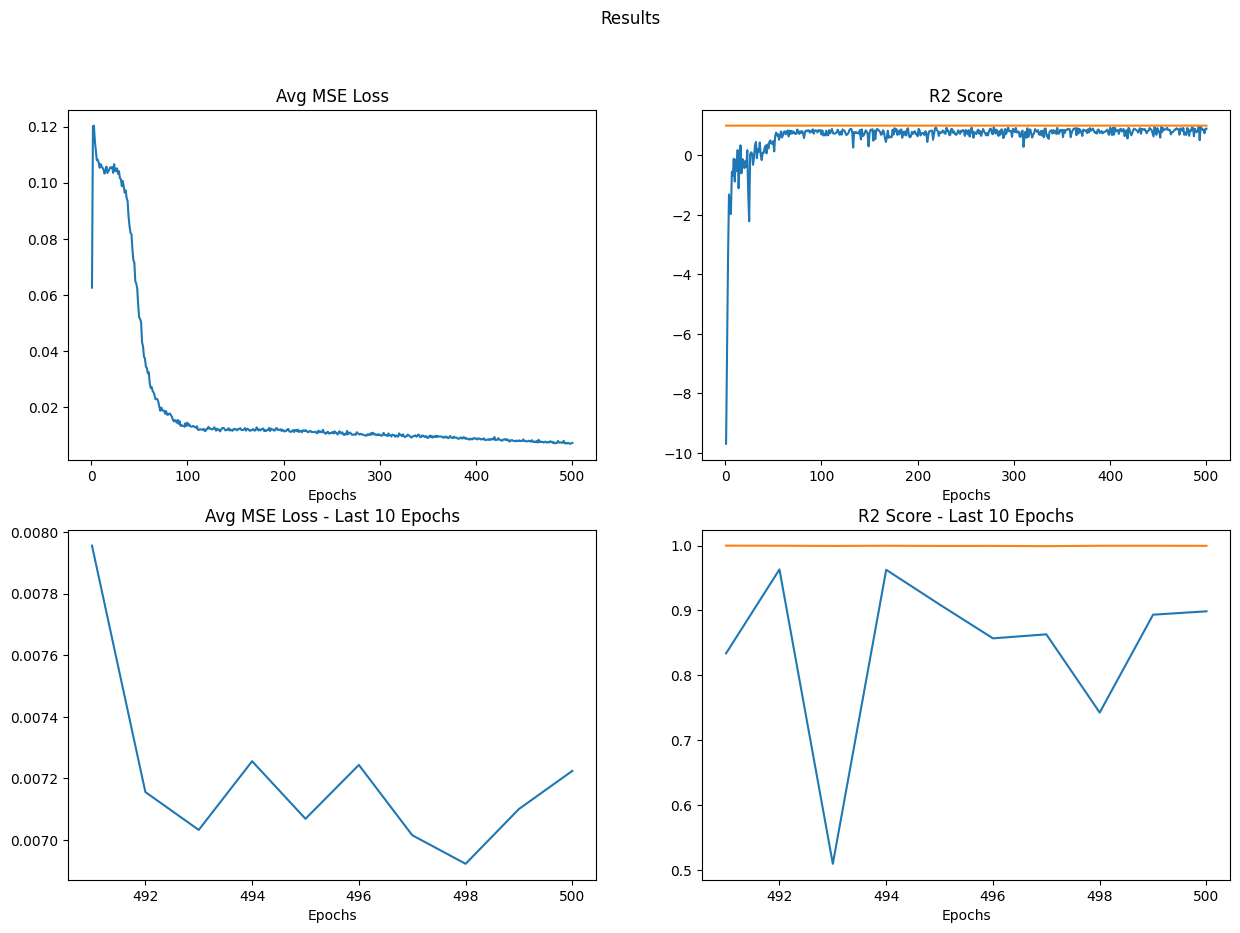

In [37]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axs[0, 0].set_title("Avg MSE Loss")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].plot(range(1, epochs + 1), arr_loss)

axs[0, 1].set_title("R2 Score")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].plot(range(1, epochs + 1), arr_r2, label="R2 Score")
axs[0, 1].plot(range(1, epochs + 1), arr_br2, label="Baseline R2 Score")

axs[1, 0].set_title("Avg MSE Loss - Last 10 Epochs")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].plot(range(epochs - 9, epochs + 1), arr_loss[-10:])

axs[1, 1].set_title("R2 Score - Last 10 Epochs")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].plot(range(epochs - 9, epochs + 1), arr_r2[-10:], label="R2 Score")
axs[1, 1].plot(range(epochs - 9, epochs + 1), arr_br2[-10:], label="Baseline R2 Score")

fig.suptitle("Results")

plt.show()